# Explore Results EMR Schwarzschild

## Import utils

In [1]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

data_path = project_path * "data/input/case_1/";
output_directory = project_path * "data/output/case_1/schwarzschild/";

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
using DelimitedFiles;
import BSON: @save, @load
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


## Data paths

In [3]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_data = true

# paths
test_name = "kan/"

output_dir = output_directory* "models/" * test_name
predictions_dir = output_dir * "predictions/"
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/";

## Load Model

In [4]:

function nn_model_case1(test:: String)
    """
    NN architectures for experiment 1
    """

    if test == "kan/"
        chain = Chain(
            x -> [x[1], x[1]],
            x -> convert.(Float32, x),
            kan.KAN([2, 3, 2]; grid_size=5, spline_order=3, scale_base=1.0, base_activation=relu), # last -> output size, first -> input size
        )
        
    elseif    test == "LSTM_dense/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            LSTM(1, 6),
            Dense(6, 10, cos),
            Dense(10,2)
        )

    elseif test == "LSTM/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            LSTM(1, 2),
            Dense(2,2)
        )

    elseif test == "LSTM_2/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            LSTM(1, 16),
            Dense(16,2)
        )

    elseif test == "LSTM_3/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            LSTM(1, 32),
            Dense(32, 32, cos),
            Dense(32,2)
        )

    elseif test == "GRU_3/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            GRU(1, 32),
            Dense(32, 32, cos),
            Dense(32,2)
        )
    
    elseif test == "GRU_2/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            GRU(1, 16),
            Dense(16,2)
        )

    elseif test == "GRU/"
        chain = Chain(
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            GRU(1, 2),
            Dense(2,2)
        )

    ########################################################################

    elseif test == "test_1_adaptative_5/"
        chain = Chain(
            x -> [cos(x[1])],
            Dense(1, 32, sigmoid), # [coef*cos(coef*x[1]) + coef*sin(coef*x[1]) for coef in x]
            x -> map(x -> x[1] + sum([coef*cos(coef*x[1]) for coef in x[2:end]]), [map(x -> x, x[1:16]), repeat(x[16:end], 1, 16)]),
            Dense(2,2)
        )

    elseif test == "test_1_custom_af/"
        chain = Chain(
        x -> [cos(x[1])],
        Dense(1, 32, custom_act_function),
        Dense(32, 32, custom_act_function),
        Dense(32, 2)
    )

    ########################################################################

    elseif test == "test_1_no_input_cos/"
    chain = Chain(x -> [x[1]],
        Dense(1,32, cos),
        Dense(32, 32, cos),
        Dense(32, 2)
    )

    elseif test == "test_3_cos/"
        chain = Chain(x -> [x[1]],
            Dense(1,32, cos),
            Dense(32, 64, cos),
            Dense(64, 32, cos),
            Dense(32, 2)
        )

    elseif test == "ori_dropout/"
        chain = Chain(
            x -> [cos(x[1])],
            Dense(1, 32, tanh),
            Dense(32, 32, tanh),
            Dropout(0.5),
            Dense(32, 2)
        )

    ########################################################################

    elseif test == "encoder/"
        chain = Chain(
            x -> convert.(Float32, x),
            x -> [cos(x[1])],
            x -> convert.(Float32, x),
            Dense(1, 32, cos),
            Dense(32, 32, cos),
            Dense(32,16, tanh),
            Dense(16, 2, tanh),
            Dense(2, 32, tanh),
            Dense(32, 2)
        )

    else
        @error "Architecture non correctly specified" * test
    end

    NN, NN_params, chain, re = process_chain(chain)

    return NN, NN_params, chain, re
end


nn_model_case1 (generic function with 1 method)

In [5]:

# Define the experimental parameters
global datasize = 250
global mass_ratio = 0.0
global dt = 100.0


## Define neural network model
_, _, chain, _ = nn_model_case1(test_name)

# load saved models
@load solutions_dir*"model_chiphi.bson" chain

# restructure chains
NN_params, re = Flux.destructure(chain)
NN(u, NN_params) = re(NN_params)(u);

Initializating weights as zero.


## Dataset

Note that here you create a new dataset for train/test purpose. It might seem a bad practice but the idea was to enable to select only what is needed for train/test. This could be easily changed and datasets for train/test process written and read in this notebook

In [6]:

datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters


χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
p=Float64(100.0); 
M=Float64(1.0); 
e_space = Float64.([0.5])
tspan_train = (0.0, 6.0f4)

println("Train dataset creation")
train_info = [];
for e in e_space 
    train_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_train, datasize, dt);
    true_info = get_true_solution_EMR_schwarzschild(train_info_i["u0"], train_info_i["model_params"], mass_ratio, M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
    push!(train_info, merge(train_info_i, true_info))
end

# TEST waveform parameters

χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
p=Float64(80.0); 
M=Float64(1.0); 
e_space = Float64.([0.4])
tspan_test = (tspan_train[2]*48, tspan_train[2]*50)
# factor = 5
# extended_tspan = (tspan_test[1], factor*tspan_test[2])

println("Test dataset creation")
test_info = [];
for e in e_space
    test_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_test, datasize, dt);
    true_info = get_true_solution_EMR_schwarzschild(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
    push!(test_info, merge(test_info_i, true_info))
end

# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);


Train dataset creation
Test dataset creation
Processing datasets
Creating test dataset 
Creating train dataset 


## Get predictions

In [7]:
# save predictions
predictions = Dict("train" => [], "test" => [])

for (set, set_data) in processed_data

    for wave in set_data

        println("Obtaining predictions for: ", set, " : ", wave["index"])

        solution_nn = Array(
            solve(wave["nn_problem"], RK4(), u0 = wave["u0"], 
            p = NN_params, saveat = wave["tsteps"], 
            dt = wave["dt_data"], adaptive=false
        ))

        predictions_wave_i = Dict()

        predictions_wave_i["tsteps"] = wave["tsteps"]
        predictions_wave_i["true_waveform"] = wave["true_waveform"]
        predictions_wave_i["pred_waveform"], _ = compute_waveform(wave["dt_data"], solution_nn, wave["q"], wave["M"], wave["model_params"])
        predictions_wave_i["pred_solution"] = solution_nn
        predictions_wave_i["true_solution"] = solution_nn
        predictions_wave_i["pred_orbit"] = soln2orbit(solution_nn, wave["M"], wave["model_params"])
        predictions_wave_i["true_orbit"] = soln2orbit(wave["true_solution"], wave["M"], wave["model_params"])    

        push!(predictions[set], predictions_wave_i)

    end

end


Obtaining predictions for: test : 1
Obtaining predictions for: train : 1


In [8]:
Flux.params(chain[3])

Params([[0.0 -0.0; 0.0 -0.0; -0.0 0.0], [0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; -0.0 0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; 0.0 0.0; 0.0 0.0;;; -0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; -0.0 -0.0; 0.0 -0.0;;; 0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; 0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 0.0; -0.0 -0.0; 0.0 -0.0], [0.0 -0.0 0.0; 0.0 0.0 0.0], [-0.0005034324513351605 0.00046353897172878337 -0.0003623579415018019; 0.0002386126930390765 -0.0009266436515334122 0.0003639609152881751;;; 0.00014183858806003766 -5.150433701408144e-5 3.169311742627918e-6; -6.722746494411832e-5 0.00010296041936353202 -3.1833319228486762e-6;;; 1.1347088679289294e-6 -5.150433701408138e-5 0.00039616391076323235; -5.378197970229554e-7 0.00010296041936353201 -0.0003979164330383837;;; -0.00012973503491506736 0.00046353897172878315 -0.0014061178375635946; 6.149072428784249e-5 -0.000926643651533412 0.0014123381235736881;;; -0.000503432451335159 0.0004635389717287825 -0.00036235794150180116; 0.0002386126930390765 -0.0009266436515334126 0

In [9]:
chain[3]

Main.kan.KAN(Main.kan.KANLinear[Main.kan.KANLinear([0.0 -0.0; 0.0 -0.0; -0.0 0.0], [0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; -0.0 0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; 0.0 0.0; 0.0 0.0;;; -0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; -0.0 -0.0; 0.0 -0.0;;; 0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; 0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 0.0; -0.0 -0.0; 0.0 -0.0], [3.872151830709467 -0.8566564359710568; 0.7068301842603407 0.7220020646923025; -1.8010031414399452 -0.9359414517188767], Float32[-2.2 -1.4 … 1.0 1.8; -1.8 -1.0 … 1.4 2.2], 5, 3, NNlib.relu, 1.0f0, 1.0f0, 0.1f0, 0.02f0, true), Main.kan.KANLinear([0.0 -0.0 0.0; 0.0 0.0 0.0], [-0.0005034324513351605 0.00046353897172878337 -0.0003623579415018019; 0.0002386126930390765 -0.0009266436515334122 0.0003639609152881751;;; 0.00014183858806003766 -5.150433701408144e-5 3.169311742627918e-6; -6.722746494411832e-5 0.00010296041936353202 -3.1833319228486762e-6;;; 1.1347088679289294e-6 -5.150433701408138e-5 0.00039616391076323235; -5.378197970229554e-7 0.0001029604193

In [10]:
chain

Chain(
  BSON.__deserialized_types__.var"#2661#2689"(),
  BSON.__deserialized_types__.var"#2662#2690"(),
  KAN(
    Array(
      Main.kan.KANLinear([0.0 -0.0; 0.0 -0.0; -0.0 0.0], [0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; -0.0 0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; 0.0 0.0; 0.0 0.0;;; -0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 -0.0; -0.0 -0.0; 0.0 -0.0;;; 0.0 -0.0; -0.0 -0.0; 0.0 0.0;;; 0.0 -0.0; 0.0 0.0; -0.0 -0.0;;; -0.0 0.0; -0.0 -0.0; 0.0 -0.0], [3.872151830709467 -0.8566564359710568; 0.7068301842603407 0.7220020646923025; -1.8010031414399452 -0.9359414517188767], Float32[-2.2 -1.4 … 1.0 1.8; -1.8 -1.0 … 1.4 2.2], 5, 3, NNlib.relu, 1.0f0, 1.0f0, 0.1f0, 0.02f0, true),  # 54 parameters  (all zero)
      Main.kan.KANLinear([0.0 -0.0 0.0; 0.0 0.0 0.0], [-0.0005034324513351605 0.00046353897172878337 -0.0003623579415018019; 0.0002386126930390765 -0.0009266436515334122 0.0003639609152881751;;; 0.00014183858806003766 -5.150433701408144e-5 3.169311742627918e-6; -6.722746494411832e-5 0.00010296041936353202

## Save predictions

In [11]:
# NOTE: this can be easily convert into a function and iterate over systems to save info

set = "train" # "test"
wave_index = 1 #

waveform_results_to_save = predictions[set][wave_index]

orbits = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_orbit_x" => waveform_results_to_save["pred_orbit"][1, :],
    "pred_orbit_y" => waveform_results_to_save["pred_orbit"][2, :],
    "true_orbit_x" => waveform_results_to_save["true_orbit"][1, :],
    "true_orbit_y" => waveform_results_to_save["true_orbit"][2, :]
)

equation_of_motion = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_solution_chi" => waveform_results_to_save["pred_solution"][1, :],
    "pred_solution_phi" => waveform_results_to_save["pred_solution"][2, :],
    "true_solution_chi" => waveform_results_to_save["true_solution"][1, :],
    "true_solution_phi" => waveform_results_to_save["true_solution"][2, :]
)

waveforms = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_waveform" => waveform_results_to_save["pred_waveform"],
    "true_waveform" => waveform_results_to_save["true_waveform"]
)


CSV.write(predictions_dir*"waveforms.csv", waveforms)
CSV.write(predictions_dir*"equation_of_motion.csv", equation_of_motion)
CSV.write(predictions_dir*"orbits.csv", orbits);

## Plots

In [12]:
plot_list = [];

for (set, set_data) in predictions

    for wave in set_data

        title = uppercasefirst(set) * " predictions"

        # waveforms
        x1 = plot(
            wave["tsteps"], wave["true_waveform"], 
            markershape=:none, alpha = 0.5, legend=false, 
            # title= title,
            label="wform data (Re)",
            xlabel="Time",
            ylabel="Waveform",
            framestyle=:box,
            linewidth = line_width,
            left_margin = 20Plots.mm,
            bottom_margin = 5Plots.mm,
            size=(1200,350),
    
            color=:black,
            seriestype=:scatter,
            ms=5,
        )
        plot!(
            x1, 
            wave["tsteps"], wave["pred_waveform"], 
            markershape=:none, linewidth = 2, alpha = 0.5, 
            label="wform NN (Re)",
                
            framestyle=:box,

            legendfontsize=legend_font_size,
            # titlefontsize=title_font_size,
            # guidefontsize=title_font_size,
            # tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
        )

        # orbits
        orbits = wave["pred_orbit"]
        N = size(orbits, 2)
        x2 = plot(
            wave["true_orbit"][1,:][1:N],
            wave["true_orbit"][2,:][1:N],
            alpha = 0.5, aspect_ratio=:equal,
            label="data",
            xlabel="x",
            ylabel="y",
    
            bottom_margin = 5Plots.mm,
    
            legendfontsize=legend_font_size,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            left_margin = 20Plots.mm,
            framestyle=:box,
            color=:black,
            legend=:outertop,  
        )
        plot!(x2, orbits[1,1:end-1], orbits[2,1:end-1],
            alpha = 0.5, 
            aspect_ratio=:equal,
            label="NN",
            framestyle=:box,
            legendfontsize=legend_font_size,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            # linestyle=:dash
        )

        plt = plot(x1, x2, layout=grid(1,2), size=(2000, 900))
        push!(plot_list, plt)
    
    end

end

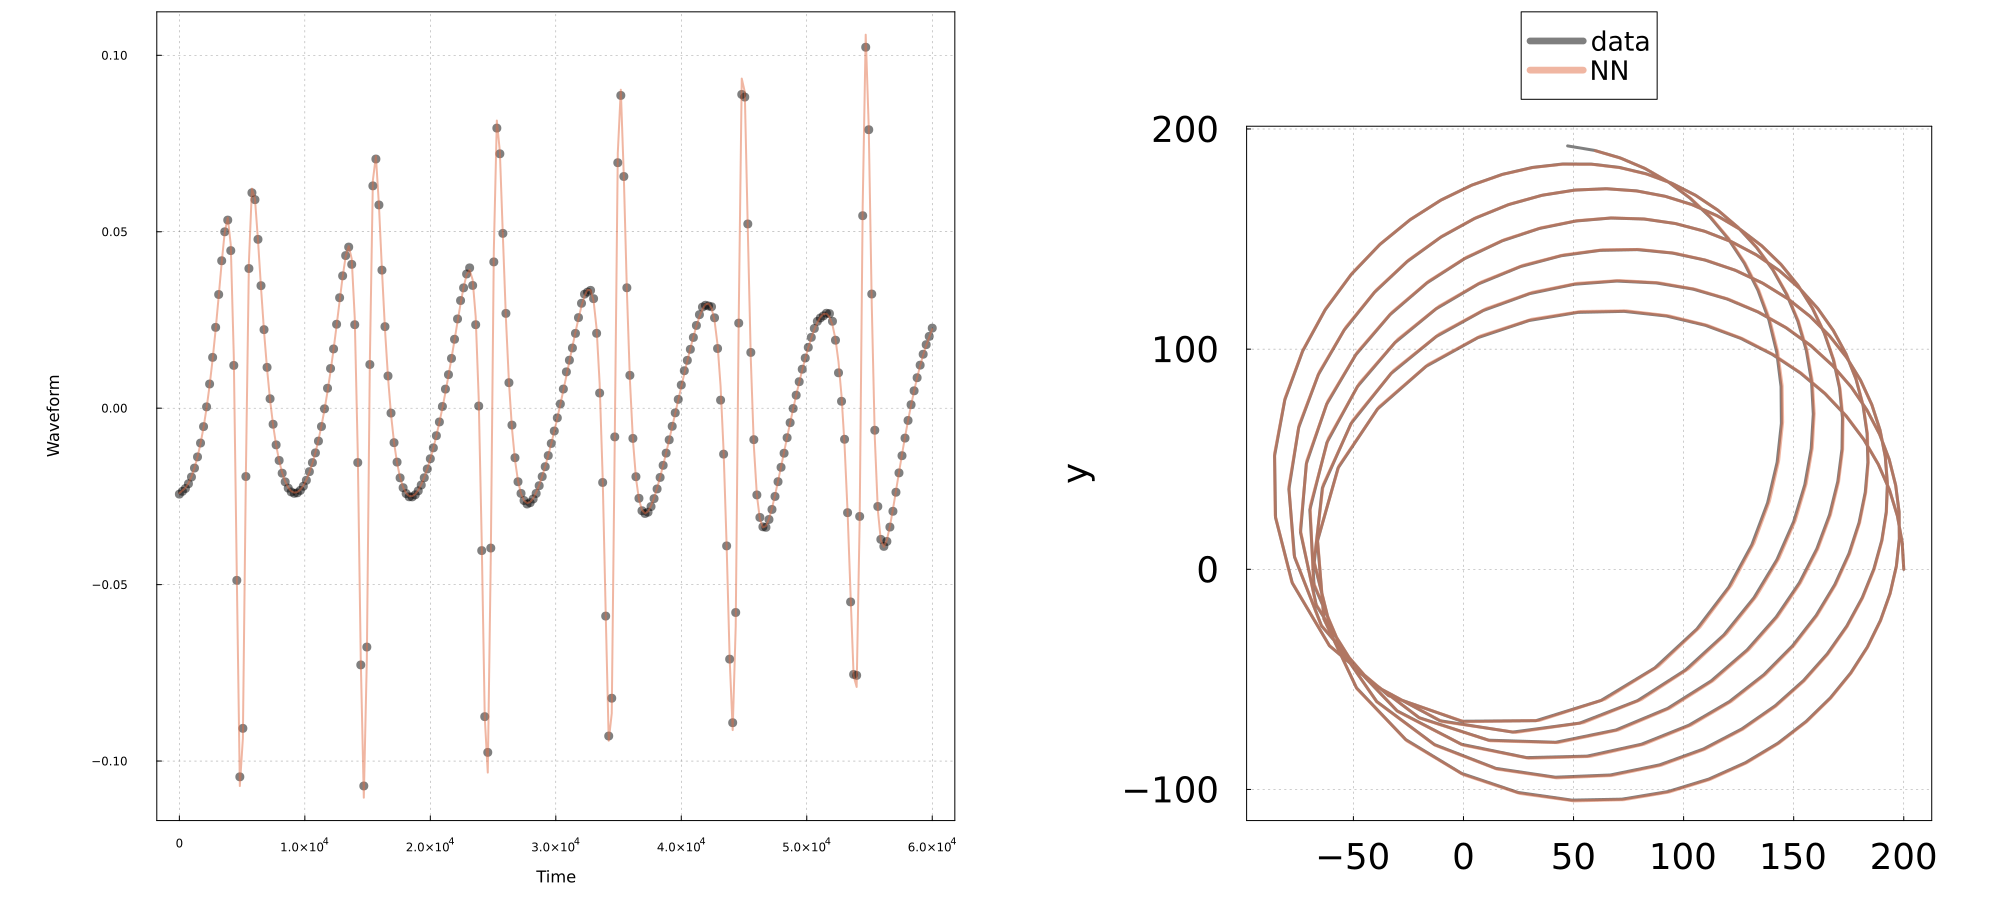

In [13]:
display(plot_list[end])

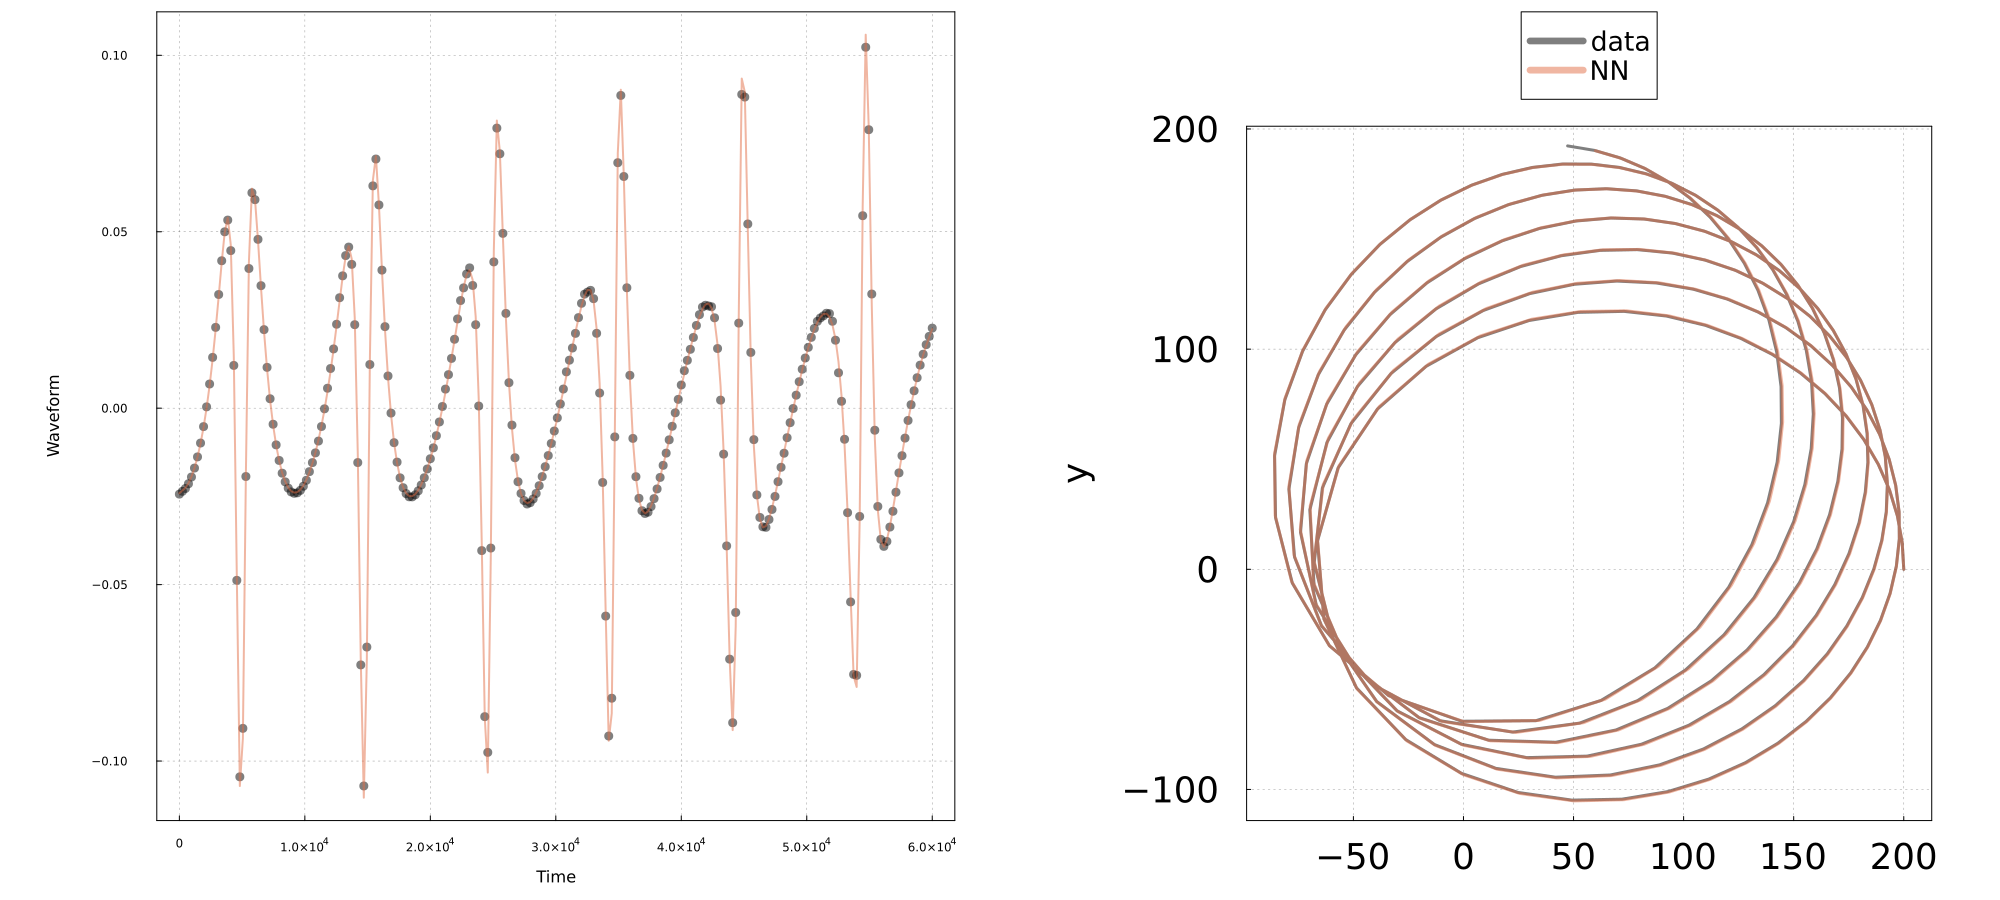

In [9]:
display(plot_list[end])

In [12]:
savefig(plot_list[end], predictions_dir*"orbits_plot.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/data/output/case_1/schwarzschild/models/test_1_cos/predictions/orbits_plot.png"